## Modeling

In [1]:
import scanpy as sc
import numpy as np 
import matplotlib.pyplot as plt


# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs

directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"    # Directory for 10k PBMCS

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    
adata_12 = adata_dict[12]
    

Total common barcodes: 11458
Total filtered gene counts: 39425571


/tmp/ipykernel_2157635/2985615530.py:97: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)
/tmp/ipykernel_2157635/2985615530.py:98: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ymax)


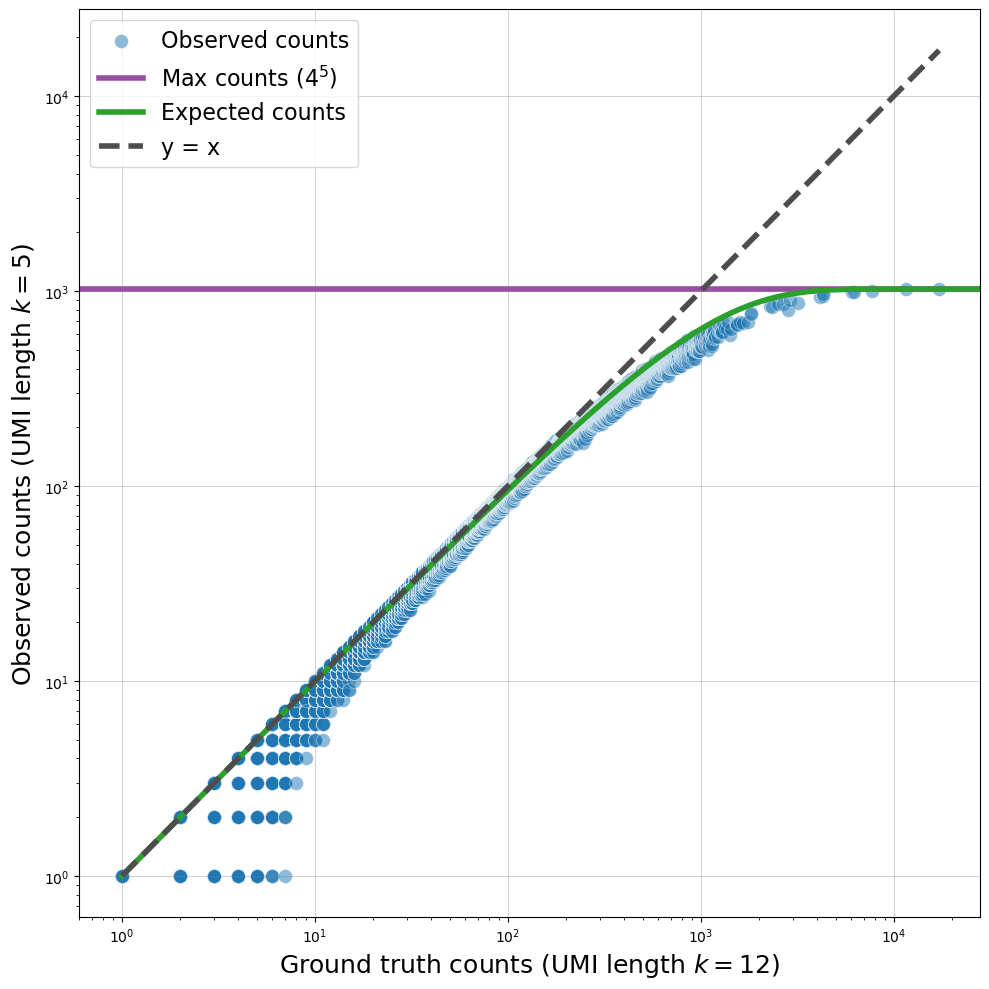

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/figures_ur/manuscript_figures/1k_PBMCs" # 1k
save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/10k_PBMCs/manuscript_figures/10k_PBMCs" # 10k
os.makedirs(save_dir, exist_ok=True)

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Initialize lists to hold all gene counts for all common cells
all_gene_counts_i = []
all_gene_counts_j = []

# Extract gene counts for each common barcode
for barcode in common_barcodes:
    # Get the gene counts for this barcode in both datasets
    gene_counts_i = adata_dict[i][barcode].X.toarray().flatten()
    gene_counts_j = adata_dict[j][barcode].X.toarray().flatten()

    # Create a boolean mask for gene_counts_i that are greater than or equal to 1
    mask = gene_counts_i >= 1 

    # Apply the mask to filter gene_counts_i and the corresponding values in gene_counts_j
    filtered_counts_i = gene_counts_i[mask] 
    filtered_counts_j = gene_counts_j[mask]

    # Append to the global lists
    all_gene_counts_i.extend(filtered_counts_i)
    all_gene_counts_j.extend(filtered_counts_j)

# Convert lists to numpy arrays
all_gene_counts_i = np.array(all_gene_counts_i)
all_gene_counts_j = np.array(all_gene_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]



In [ ]:
# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

# Plot the model
model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=4, 
    label='Expected counts'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left",fontsize=16)  # Or any other position

plt.tight_layout()

# Save and show the plot
plt.savefig(f"{save_dir}/UMI_12_vs_{j}_all_cells.jpg", format='jpg', dpi=300)
plt.show()
plt.close()


#### Optimized version 

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/figures_ur/manuscript_figures" # 1k
save_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/figures_ur/manuscript_figures/10k_PBMCs" # 10k
os.makedirs(save_dir, exist_ok=True)

# Ensure both datasets are properly aligned
common_barcodes = sorted(set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

# Slice both AnnData objects to get corresponding matrices
adata_i = adata_dict[i][common_barcodes]
adata_j = adata_dict[j][common_barcodes]

# Extract full count matrices
X_i = adata_i.X.toarray()
X_j = adata_j.X.toarray()

# Apply filtering mask where counts from UMI length 12 are >= 1
mask = X_i >= 1
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

print(f"Total filtered gene counts: {len(filtered_counts_i)}")

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(filtered_counts_i)
sorted_gene_counts_i = filtered_counts_i[sorted_indices]
sorted_gene_counts_j = filtered_counts_j[sorted_indices]

# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Observed counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

# Plot the model
model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=4, 
    label='Expected counts'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)  # Or any other position

plt.tight_layout()

# Save and show the plot
plt.savefig(f"{save_dir}/UMI_12_vs_{j}_all_cells.jpg", format='jpg', dpi=300)
plt.show()
plt.close()


Total common barcodes: 11458


### Doing it as pdf, samping points 

Total common barcodes: 1232


Total filtered gene counts: 4283700


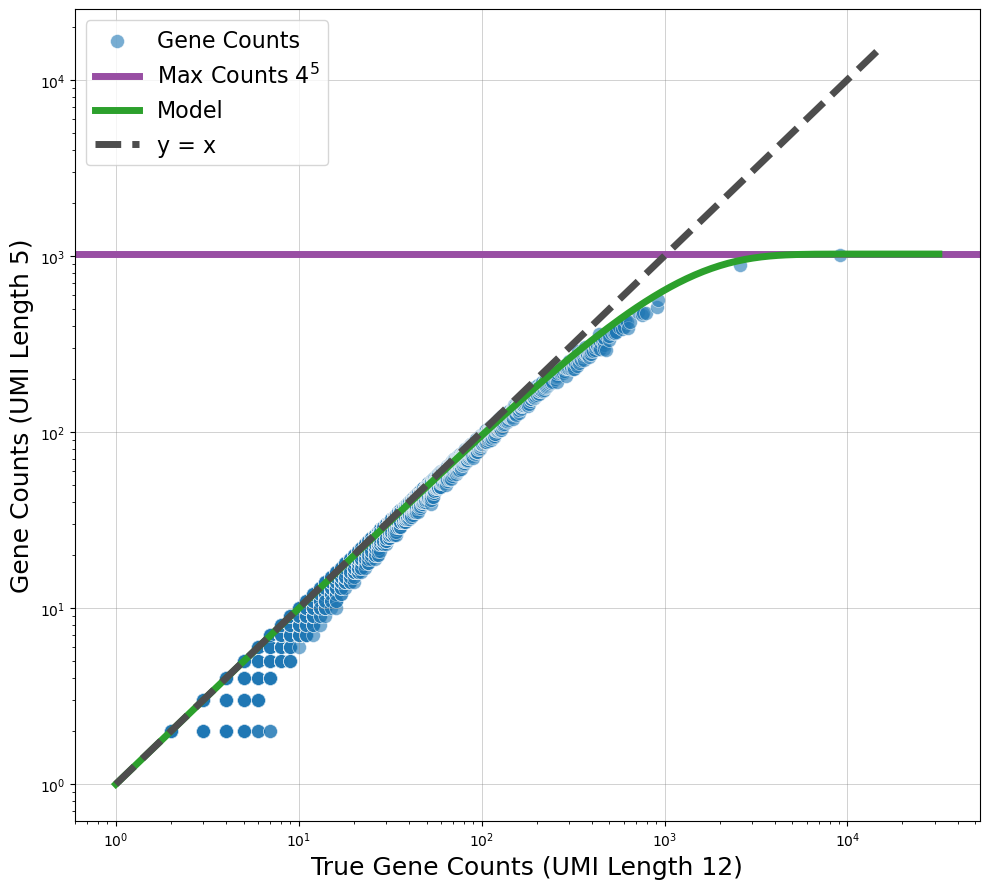

In [6]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import scanpy as sc

# # Your model function
# def f(n_vals, j):
#     return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# # Fixed UMI length for "true" counts
# i = 12
# j = 5  # Only generate for UMI 5
# n_values = np.logspace(0, 4.5, 200)

# # Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures"
# os.makedirs(save_dir, exist_ok=True)

# # Ensure both datasets are properly aligned
# common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
# print(f"Total common barcodes: {len(common_barcodes)}")

# # Initialize lists to hold all gene counts for all common cells
# all_gene_counts_i = []
# all_gene_counts_j = []

# # Extract gene counts for each common barcode
# for barcode in common_barcodes:
#     # Get the gene counts for this barcode in both datasets
#     gene_counts_i = adata_dict[i][barcode].X.toarray().flatten()
#     gene_counts_j = adata_dict[j][barcode].X.toarray().flatten()

#     # Create a boolean mask for gene_counts_i that are greater than or equal to 1
#     mask = gene_counts_i >= 1 

#     # Apply the mask to filter gene_counts_i and the corresponding values in gene_counts_j
#     filtered_counts_i = gene_counts_i[mask]   # +1 for log scale
#     filtered_counts_j = gene_counts_j[mask] 

#     # Append to the global lists
#     all_gene_counts_i.extend(filtered_counts_i)
#     all_gene_counts_j.extend(filtered_counts_j)

# # Convert lists to numpy arrays
# all_gene_counts_i_real = np.array(all_gene_counts_i)
# all_gene_counts_j_real = np.array(all_gene_counts_j)

# print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# # ─── Randomly Sample 500,000 Points ─────────────────────────────────────────
# if len(all_gene_counts_i) > 500000:
#     sample_indices = np.random.choice(len(all_gene_counts_i_real), 500000, replace=False)
#     all_gene_counts_i = all_gene_counts_i_real[sample_indices]
#     all_gene_counts_j = all_gene_counts_j_real[sample_indices]

# # Sort the gene counts based on gene_counts_i
# sorted_indices = np.argsort(all_gene_counts_i)
# sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
# sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# # Create plot
# plt.figure(figsize=(10, 9))
# plt.scatter(
#     sorted_gene_counts_i, 
#     sorted_gene_counts_j, 
#     alpha=0.6, 
#     c='#1f77b4',  # Standard Blue for Points
#     edgecolors='w', 
#     s=100,             # Increased marker size (was 50)
#     linewidth=0.5, 
#     label='Gene Counts'
# )

# # Add the asymptotic line for UMI 5
# y_asymptotic_value = 4**j
# plt.axhline(
#     y=y_asymptotic_value, 
#     color='#984ea3', 
#     linestyle='-', 
#     linewidth=5, 
#     label=f'Max Counts $4^{{{j}}}$'
# )

# # Plot the model
# model_vals = f(n_values, j)
# plt.plot(
#     n_values, 
#     model_vals, 
#     color='#2ca02c',  # Standard Green for Model Line
#     linewidth=5, 
#     label='Model'
# )

# # Reference y = x line
# max_val = max(all_gene_counts_i_real.max(), all_gene_counts_j_real.max())
# plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=5, label='y = x')

# # Axis scaling and labels
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
# plt.ylabel('Gene Counts (UMI Length 5)', fontsize=18)
# plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
# plt.legend(loc="upper left", fontsize=16)

# plt.tight_layout()

# # Save and show the plot
# plt.savefig(f"{save_dir}/UMI_12_vs_5_all_cells.pdf")
# plt.show()
# plt.close()


#### Plotting y - f(x)

Total common barcodes: 1232
Total filtered gene counts (count > 100): 10195
Negative Residuals: 9986 (97.95%)
Positive Residuals: 209 (2.05%)
Zero Residuals: 0 (0.00%)
Mean Residual: -10.89
Median Residual: -8.01


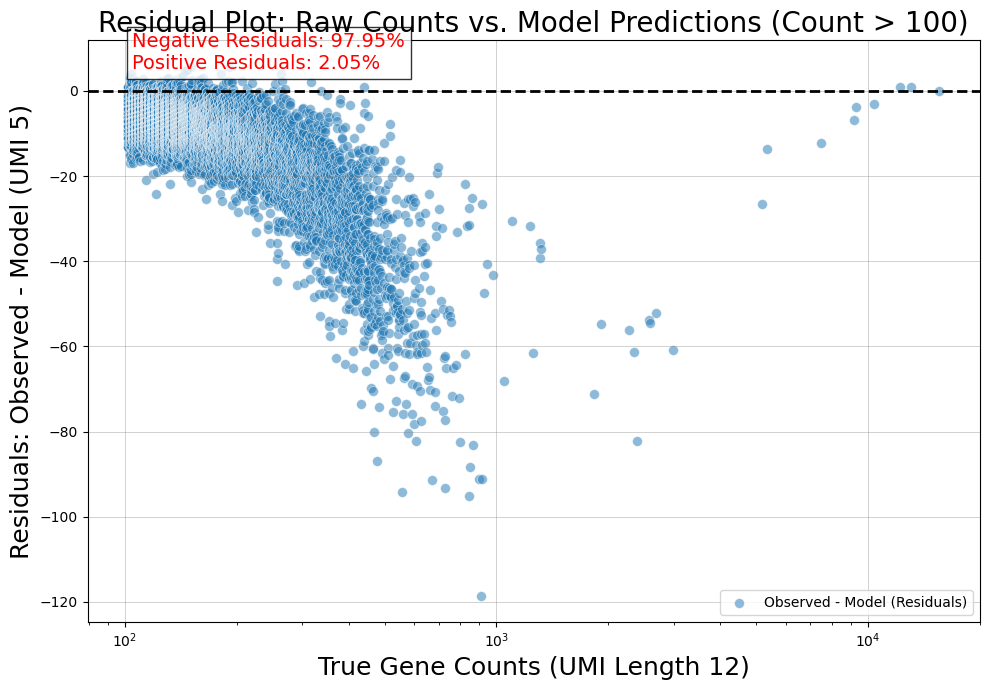

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Output directory
save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures"
os.makedirs(save_dir, exist_ok=True)

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Initialize lists to hold all gene counts for all common cells
all_gene_counts_i = []
all_gene_counts_j = []

# Extract gene counts for each common barcode
for barcode in common_barcodes:
    # Get the gene counts for this barcode in both datasets
    gene_counts_i = adata_dict[i][barcode].X.toarray().flatten()
    gene_counts_j = adata_dict[j][barcode].X.toarray().flatten()

    # Create a boolean mask for gene_counts_i that are greater than or equal to 100
    mask = gene_counts_i > 100

    # Apply the mask to filter gene_counts_i and the corresponding values in gene_counts_j
    filtered_counts_i = gene_counts_i[mask] + 1  # +1 for log scale
    filtered_counts_j = gene_counts_j[mask] + 1

    # Append to the global lists
    all_gene_counts_i.extend(filtered_counts_i)
    all_gene_counts_j.extend(filtered_counts_j)

# Convert lists to numpy arrays
all_gene_counts_i = np.array(all_gene_counts_i)
all_gene_counts_j = np.array(all_gene_counts_j)

print(f"Total filtered gene counts (count > 100): {len(all_gene_counts_i)}")

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Calculate the model predictions for the sorted true counts
model_predictions = f(sorted_gene_counts_i, j)

# Calculate the difference (y - f(x))
residuals = sorted_gene_counts_j - model_predictions

# Calculate percentages of negative and positive residuals
negative_residuals = np.sum(residuals < 0)
positive_residuals = np.sum(residuals > 0)
zero_residuals = np.sum(residuals == 0)
total_residuals = len(residuals)

percent_negative = (negative_residuals / total_residuals) * 100
percent_positive = (positive_residuals / total_residuals) * 100
percent_zero = (zero_residuals / total_residuals) * 100

# Calculate mean and median of residuals
mean_residual = np.mean(residuals)
median_residual = np.median(residuals)

print(f"Negative Residuals: {negative_residuals} ({percent_negative:.2f}%)")
print(f"Positive Residuals: {positive_residuals} ({percent_positive:.2f}%)")
print(f"Zero Residuals: {zero_residuals} ({percent_zero:.2f}%)")
print(f"Mean Residual: {mean_residual:.2f}")
print(f"Median Residual: {median_residual:.2f}")

# Create the residual plot
plt.figure(figsize=(10, 7))
plt.scatter(
    sorted_gene_counts_i, 
    residuals, 
    alpha=0.5, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=50,             
    linewidth=0.5, 
    label='Observed - Model (Residuals)'
)

# Reference line at y = 0 (no bias)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
# plt.axhline(mean_residual, color='green', linestyle='--', linewidth=2, label=f'Mean Residual: {mean_residual:.2f}')
# plt.axhline(median_residual, color='orange', linestyle='--', linewidth=2, label=f'Median Residual: {median_residual:.2f}')

# Display percentages and stats on the plot
plt.text(0.05, 0.95, 
         f'Negative Residuals: {percent_negative:.2f}%\n'
         f'Positive Residuals: {percent_positive:.2f}%', 
         transform=plt.gca().transAxes, 
         fontsize=14, 
         color='red', 
         bbox=dict(facecolor='white', alpha=0.8))

# Axis scaling and labels
plt.xscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel('Residuals: Observed - Model (UMI 5)', fontsize=18)
plt.title('Residual Plot: Raw Counts vs. Model Predictions (Count > 100)', fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="lower right")
plt.tight_layout()

# Save and show the plot
# plt.savefig(f"{save_dir}/UMI_12_vs_{j}_residual_plot_with_stats_filtered.jpg", format='jpg', dpi=300)
plt.show()
plt.close()


## Inverting Plot

In [9]:
import scanpy as sc
import numpy as np 
import matplotlib.pyplot as plt

# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"  # Directory for 1k_PBMCs

directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/"    # Directory for 10k PBMCS

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_inverted_{i}.h5ad")
    
print(adata_dict[6])


# Load the ground truth vector 

# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad") #1k_PBMCs
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad") #10k PBMCs
adata_12

AnnData object with n_obs × n_vars = 11458 × 33100


AnnData object with n_obs × n_vars = 11458 × 33100

Total common barcodes: 11458


/tmp/ipykernel_2114579/1957037105.py:69: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)
/tmp/ipykernel_2114579/1957037105.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ymax)


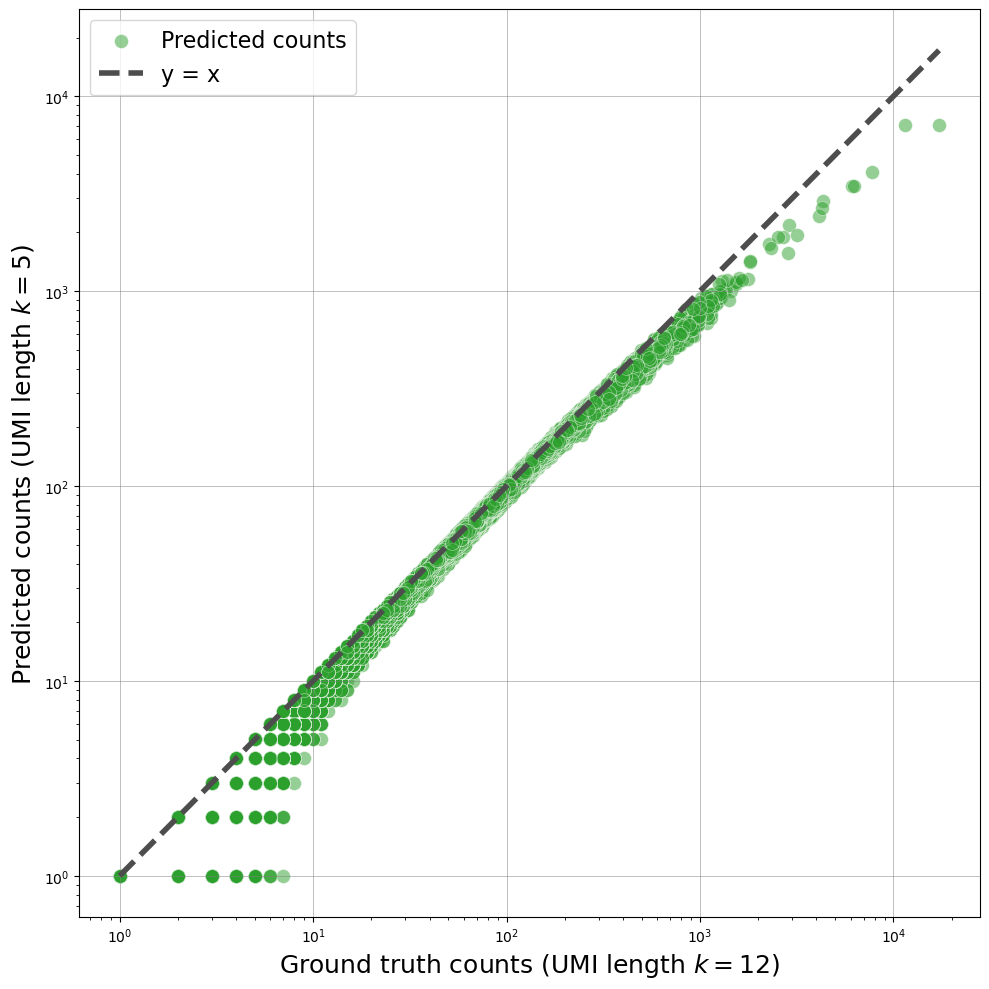

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Define parameters
i = 12
j = 5

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Initialize lists to hold all gene counts for all common cells
all_gene_counts1 = []
all_gene_counts2 = []

# Extract gene counts for each common barcode
for barcode in common_barcodes:
    # Get the gene counts for this barcode in both datasets
    gene_counts1 = adata_dict[i][barcode].X.toarray().flatten()
    gene_counts2 = adata_dict[j][barcode].X.toarray().flatten()

    # Create a boolean mask for gene_counts1 that are greater than or equal to 1
    mask = gene_counts1 >= 1 

    # Apply the mask to filter gene_counts1 and the corresponding values in gene_counts2
    filtered_counts1 = gene_counts1[mask]  # +1 for log scale
    filtered_counts2 = gene_counts2[mask] 

    # Append to the global lists
    all_gene_counts1.extend(filtered_counts1)
    all_gene_counts2.extend(filtered_counts2)

# Convert lists to numpy arrays
all_gene_counts1 = np.array(all_gene_counts1)
all_gene_counts2 = np.array(all_gene_counts2)

# Plotting
plt.figure(figsize=(10, 10))

plt.scatter(
    all_gene_counts1, 
    all_gene_counts2, 
    alpha=0.5, 
    c='#2ca02c',  # Default green
    edgecolors='w', 
    s=100, 
    linewidth=0.5, 
    label='Predicted counts'
)


# Adding the identity line
max_val = max(all_gene_counts1.max(), all_gene_counts2.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Calculate function values for plotting
n_values = np.logspace(0, 4.5, 200)
f_n_4j = f(n_values, j)

# Log scale for both axes
plt.xscale('log')
plt.yscale('log')

ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)

# Labels and legend
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.ylabel(f'Predicted counts (UMI length $k=5$)', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(loc="upper left",fontsize=16)  # Or any other position
plt.tight_layout()

save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs"

# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_PBMCs"
plt.savefig(f"{save_dir}/inverted_UMI_12_vs_{j}_all_cells.jpg", format='jpg', dpi=300)
plt.show()





#### Optimized

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Define parameters
i = 12
j = 5

# Ensure both datasets are properly aligned
common_barcodes = sorted(set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

# Extract matrices once using shared barcodes
adata1 = adata_dict[i][common_barcodes]
adata2 = adata_dict[j][common_barcodes]
X1 = adata1.X.toarray()
X2 = adata2.X.toarray()

# Create mask and apply it
mask = X1 >= 1
all_gene_counts1 = X1[mask]
all_gene_counts2 = X2[mask]

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(
    all_gene_counts1, 
    all_gene_counts2, 
    alpha=0.5, 
    c='#1f77b4', 
    edgecolors='w', 
    s=100, 
    linewidth=0.5, 
    label='Observed counts'
)

# Adding the identity line
max_val = max(all_gene_counts1.max(), all_gene_counts2.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

# Calculate function values for plotting
n_values = np.logspace(0, 4.5, 200)
f_n_4j = f(n_values, j)

# Log scale for both axes
plt.xscale('log')
plt.yscale('log')

ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)

# Labels and legend
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.ylabel(f'Predicted counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(loc="upper left",fontsize=16)  # Or any other position
plt.tight_layout()

save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs"
plt.savefig(f"{save_dir}/inverted_UMI_12_vs_{j}_all_cells.jpg", format='jpg', dpi=300)
plt.show()


### Plotting sampling points, pdf


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
# def f(n_vals, j):
#     return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# # Define parameters
# i = 12
# j = 5

# # Ensure both datasets are properly aligned
# common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
# print(f"Total common barcodes: {len(common_barcodes)}")

# # Initialize lists to hold all gene counts for all common cells
# all_gene_counts1 = []
# all_gene_counts2 = []

# # Extract gene counts for each common barcode
# for barcode in common_barcodes:
#     # Get the gene counts for this barcode in both datasets
#     gene_counts1 = adata_dict[i][barcode].X.toarray().flatten()
#     gene_counts2 = adata_dict[j][barcode].X.toarray().flatten()

#     # Create a boolean mask for gene_counts1 that are greater than or equal to 1
#     mask = gene_counts1 >= 1 

#     # Apply the mask to filter gene_counts1 and the corresponding values in gene_counts2
#     filtered_counts1 = gene_counts1[mask] + 1  # +1 for log scale
#     filtered_counts2 = gene_counts2[mask] + 1

#     # Append to the global lists
#     all_gene_counts1.extend(filtered_counts1)
#     all_gene_counts2.extend(filtered_counts2)

# # Convert lists to numpy arrays
# all_gene_counts1_real = np.array(all_gene_counts1)
# all_gene_counts2_real = np.array(all_gene_counts2)

# # ─── Randomly Sample 500,000 Points ─────────────────────────────────────────
# if len(all_gene_counts1) > 500000:
#     sample_indices = np.random.choice(len(all_gene_counts1_real), 500000, replace=False)
#     all_gene_counts1 = all_gene_counts1_real[sample_indices]
#     all_gene_counts2 = all_gene_counts2_real[sample_indices]

# # Plotting
# plt.figure(figsize=(10, 9))
# plt.scatter(
#     all_gene_counts1, 
#     all_gene_counts2, 
#     alpha=0.5, 
#     c='#1f77b4', 
#     edgecolors='w', 
#     s=100, 
#     linewidth=0.5, 
#     label='Gene Counts'
# )

# # Adding the identity line
# max_val = max(all_gene_counts1_real.max(), all_gene_counts2_real.max())
# plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=5, label='y = x')

# # Calculate function values for plotting
# n_values = np.logspace(0, 4.5, 200)
# f_n_4j = f(n_values, j)

# # Log scale for both axes
# plt.xscale('log')
# plt.yscale('log')

# # Labels and legend
# plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
# plt.ylabel(f'Predicted Counts (UMI Length {j})', fontsize=18)
# plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
# plt.legend(loc="upper left", fontsize=16)  # Or any other position

# # Save as a high-resolution PDF
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures"
# plt.savefig(f"{save_dir}/inverted_UMI_12_vs_{j}_all_cells.pdf")
# plt.show()


## Confusion Matrices

#### Naive


Processing UMI length = 3 …


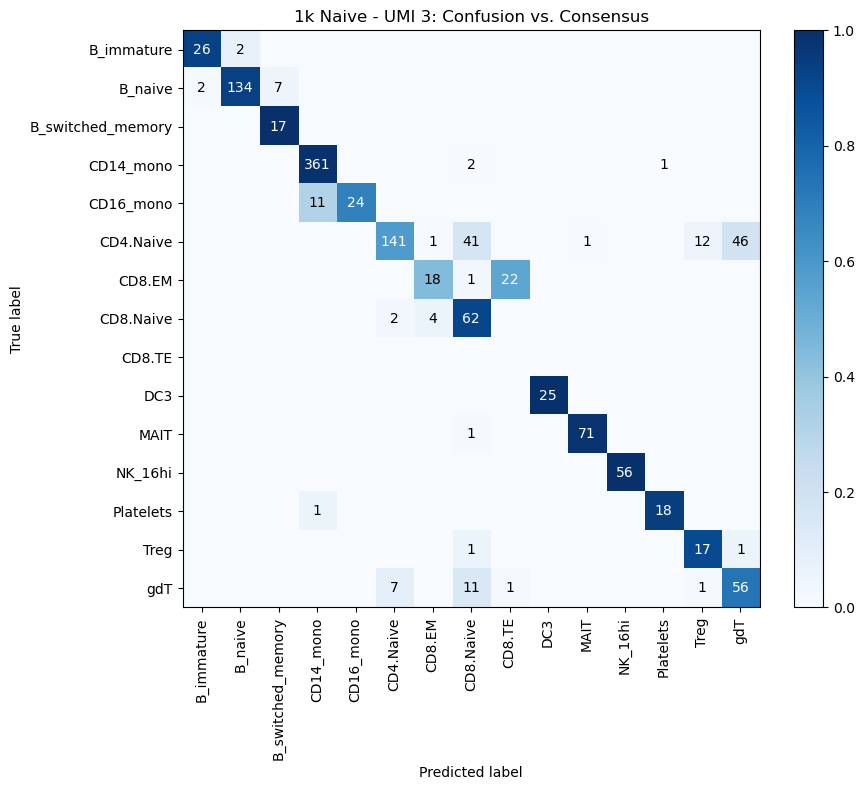

In [20]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
# base_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices" # 1k_PBMCs
base_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices" 
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build consensus from UMI 8–12

# load the five Adatas
ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

# intersect on common cells
common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

# majority-vote consensus labels
consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these three from the axes
exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Only process UMI length of 3
umi = 3
print(f"\nProcessing UMI length = {umi} …")

# load this UMI’s AnnData
adata = sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{umi}.h5ad"))

# align to consensus cells
if not all(adata.obs_names == common_cells):
    cells = [c for c in common_cells if c in adata.obs_names]
    print(f"  Aligning to {len(cells)} common cells")
    adata = adata[cells].copy()

# extract true vs. pred
y_true = np.array([consensus_labels[c] for c in adata.obs_names], dtype=str)
y_pred = adata.obs['majority_voting'].astype(str).values

# determine labels (minus excludes)
labs = np.unique(np.concatenate([y_true, y_pred]))
labels = [L for L in labs if L not in exclude]
n = len(labels)

# raw confusion counts
cm = confusion_matrix(y_true, y_pred, labels=labels)

# row-normalize to get proportions, but set rows with sum=0 to zeros
row_sums = cm.sum(axis=1, keepdims=True)
cm_prop = np.divide(
    cm.astype(float),
    row_sums,
    out=np.zeros_like(cm, dtype=float),
    where=row_sums != 0
)

# ─── Plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)

# ticks & labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"1k Naive - UMI {umi}: Confusion vs. Consensus")

# annotate with raw counts, text color by proportion
thresh = 0.5
for r in range(n):
    for c in range(n):
        count = cm[r, c]
        if count == 0:
            continue
        color = "white" if cm_prop[r, c] > thresh else "black"
        ax.text(c, r, str(count), ha="center", va="center", color=color)

# colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/confusion_matrix_UMI_{umi}.pdf")
plt.show()




Processing UMI length = 3 …


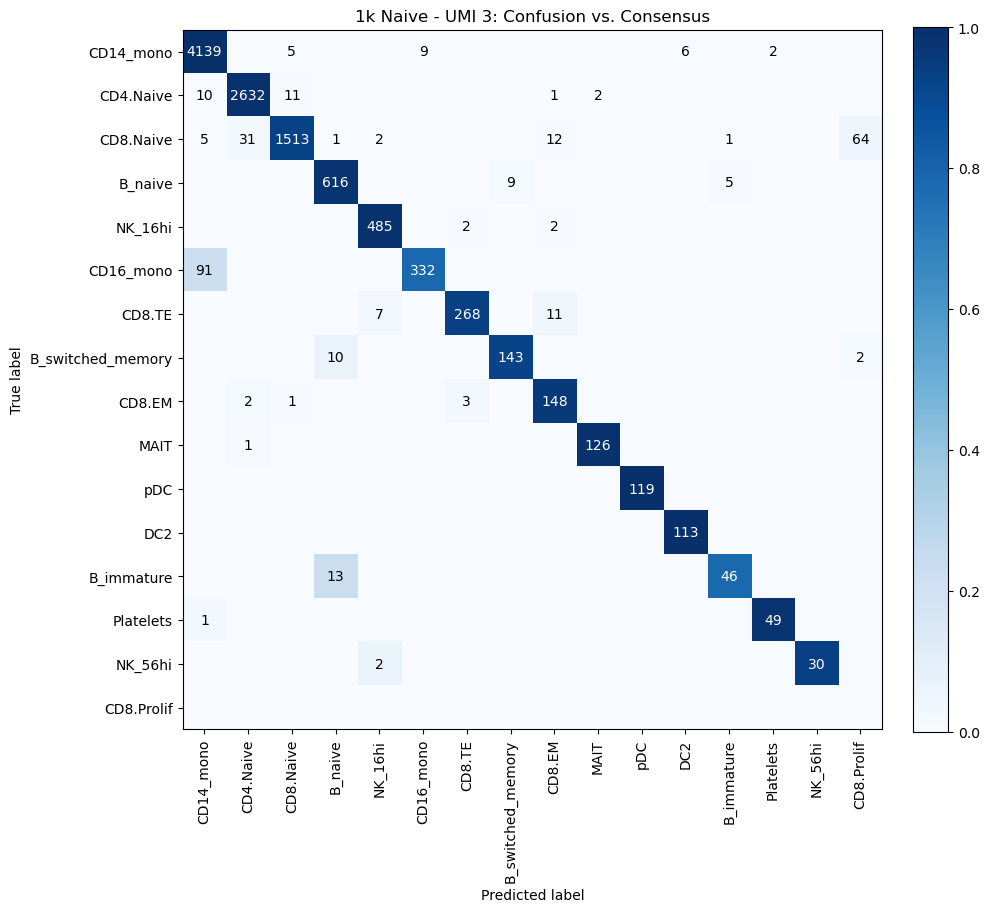

In [4]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
# base_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices" #1k_PBMCs
base_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices" #10 PBMCs

# ──────────────────────────────────────────────────────────────────────────────
# 1) Build consensus from UMI 8–12

ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these three from the axes
# exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"} # 1k 
exclude = {
    "B_exhausted",
    "B_non-switched_memory",
    "CD4.Prolif",
    "DC1",
    "HSC_CD38pos",
    "HSC_erythroid",
    "gdT",
    "Plasma_cell_IgA"
} #10k

# ──────────────────────────────────────────────────────────────────────────────
# 3) Only process UMI length of 3
umi = 3
print(f"\nProcessing UMI length = {umi} …")

adata = sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{umi}.h5ad"))
if not all(adata.obs_names == common_cells):
    cells = [c for c in common_cells if c in adata.obs_names]
    print(f"  Aligning to {len(cells)} common cells")
    adata = adata[cells].copy()

y_true = np.array([consensus_labels[c] for c in adata.obs_names], dtype=str)
y_pred = adata.obs['majority_voting'].astype(str).values

labs = np.unique(np.concatenate([y_true, y_pred]))
labels = [L for L in labs if L not in exclude]
n = len(labels)

cm = confusion_matrix(y_true, y_pred, labels=labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_prop = np.divide(
    cm.astype(float),
    row_sums,
    out=np.zeros_like(cm, dtype=float),
    where=row_sums != 0
)

# ─── REORDER BOTH ROWS & COLUMNS by total true-counts ─────────────────────────
total_counts = cm.sum(axis=1)
order = np.argsort(-total_counts)
cm = cm[order][:, order]
cm_prop = cm_prop[order][:, order]
labels = [labels[idx] for idx in order]
# ──────────────────────────────────────────────────────────────────────────────

# ─── Plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"1k Naive - UMI {umi}: Confusion vs. Consensus")

thresh = 0.5
for r in range(n):
    for c in range(n):
        count = cm[r, c]
        if count == 0:
            continue
        color = "white" if cm_prop[r, c] > thresh else "black"
        ax.text(c, r, str(count), ha="center", va="center", color=color)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/naive_confusion_matrix_UMI_{umi}.pdf")
plt.show()


### Model

Uniform consensus:   1028/1232 = 83.44%
Mixed consensus:     204/1232 = 16.56%

Processing UMI length = 3 …


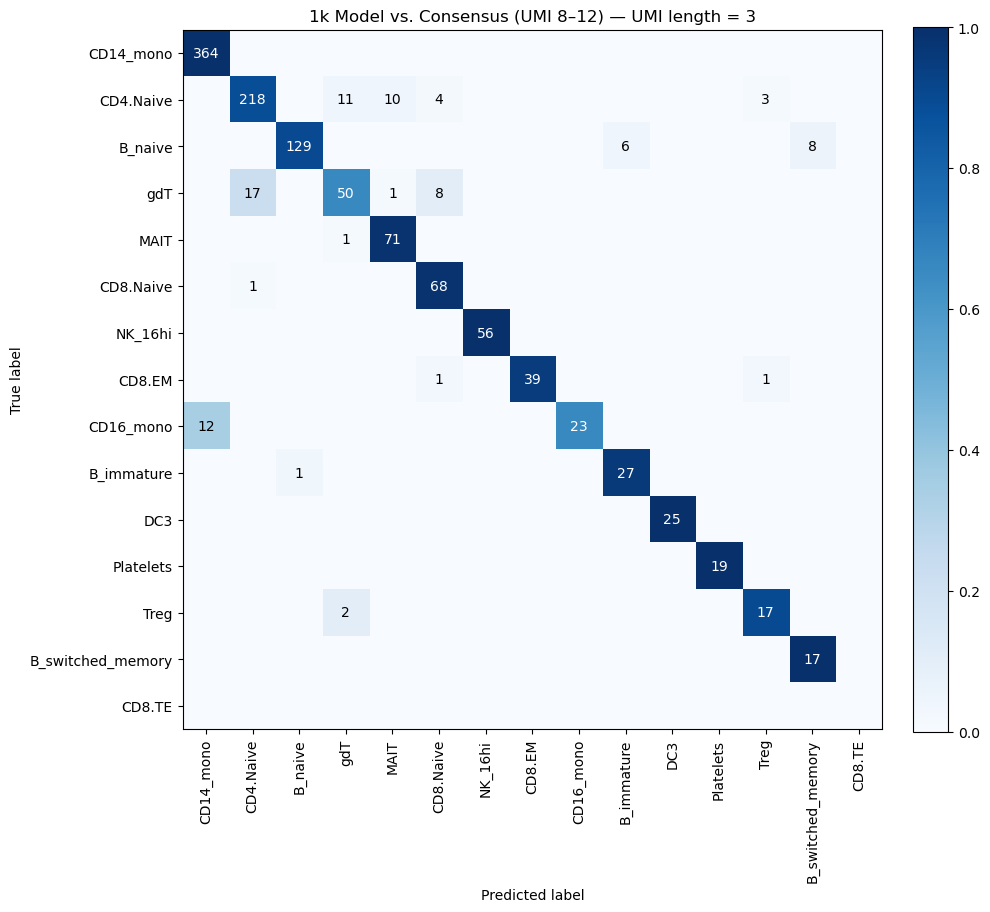

In [1]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
# model_common_path     = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"
# consensus_base_path   = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

model_common_path     = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"
consensus_base_path   = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# ──────────────────────────────────────────────────────────────────────────────
# 1) Load ground‐truth Adatas (UMI 8–12) and build consensus
ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(consensus_base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these from the axes
exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Print uniform‐vote stats once
total       = len(common_cells)
uniform     = sum(
    1 for c in common_cells
    if len({ensemble_adatas[i].obs.loc[c, 'majority_voting'] for i in range(8, 13)}) == 1
)
non_uniform = total - uniform
print(f"Uniform consensus:   {uniform}/{total} = {uniform/total*100:.2f}%")
print(f"Mixed consensus:     {non_uniform}/{total} = {non_uniform/total*100:.2f}%\n")

# ──────────────────────────────────────────────────────────────────────────────
# 4) Only process UMI length of 3
umi = 3
print(f"Processing UMI length = {umi} …")
    
# load inverted‐model AnnData
inv_file = os.path.join(model_common_path, f"annotated_adata_{umi}.h5ad")
inv_adata = sc.read_h5ad(inv_file)
    
# align to consensus cells
if not all(inv_adata.obs_names == common_cells):
    cells = [c for c in common_cells if c in inv_adata.obs_names]
    print(f"  Aligning to {len(cells)} common cells")
    inv_adata = inv_adata[cells].copy()
    
# extract true vs. pred
y_true = np.array([consensus_labels[c] for c in inv_adata.obs_names], dtype=str)
y_pred = inv_adata.obs['majority_voting'].astype(str).values

# determine labels (add "CD8.TE" if not already included)
labs = np.unique(np.concatenate([y_true, y_pred, ["CD8.TE"]]))
labels = [L for L in labs if L not in exclude]
n = len(labels)
    
# raw confusion counts
cm = confusion_matrix(y_true, y_pred, labels=labels)
    
# row‐normalize (safe divide: zero‐rows → all zeros)
row_sums = cm.sum(axis=1, keepdims=True)
cm_prop = np.divide(
    cm.astype(float),
    row_sums,
    out=np.zeros_like(cm, dtype=float),
    where=row_sums != 0
)

# ─── NEW: reorder BOTH rows & columns by descending true‐label totals ────────
total_counts = cm.sum(axis=1)
order = np.argsort(-total_counts)
cm       = cm[order][:, order]
cm_prop  = cm_prop[order][:, order]
labels   = [labels[idx] for idx in order]
# ──────────────────────────────────────────────────────────────────────────────

# ─── Plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)
    
# ticks & labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"1k Model vs. Consensus (UMI 8–12) — UMI length = {umi}")
    
# annotate with raw counts; text white if prop>0.5
thresh = 0.5
for r in range(n):
    for c in range(n):
        cnt = cm[r, c]
        if cnt == 0:
            continue
        color = "white" if cm_prop[r, c] > thresh else "black"
        ax.text(c, r, str(cnt), ha="center", va="center", color=color)
    
# colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/model_confusion_matrix_UMI_{umi}.pdf")
plt.show()


## TVD Plot - MAE

[0.3165715428360171, 0.19023317437643877, 0.09543584576054018, 0.046006365471098654, 0.024688917650343926, 0.016385678564693022, 0.01309353791568422, 0.011437934008612755, 0.010118433448483101, 0.008209893794435293, 0.00563848297898409, 0.0]
[0.26323935514680163, 0.10143428050181967, 0.04752271722811643, 0.028378461948891636, 0.01916105406658939, 0.014872022739751788, 0.012717463393836087, 0.011354311567887476, 0.010100494919389401, 0.008205764109746093, 0.005637517726288829, 5.445217260568026e-07]


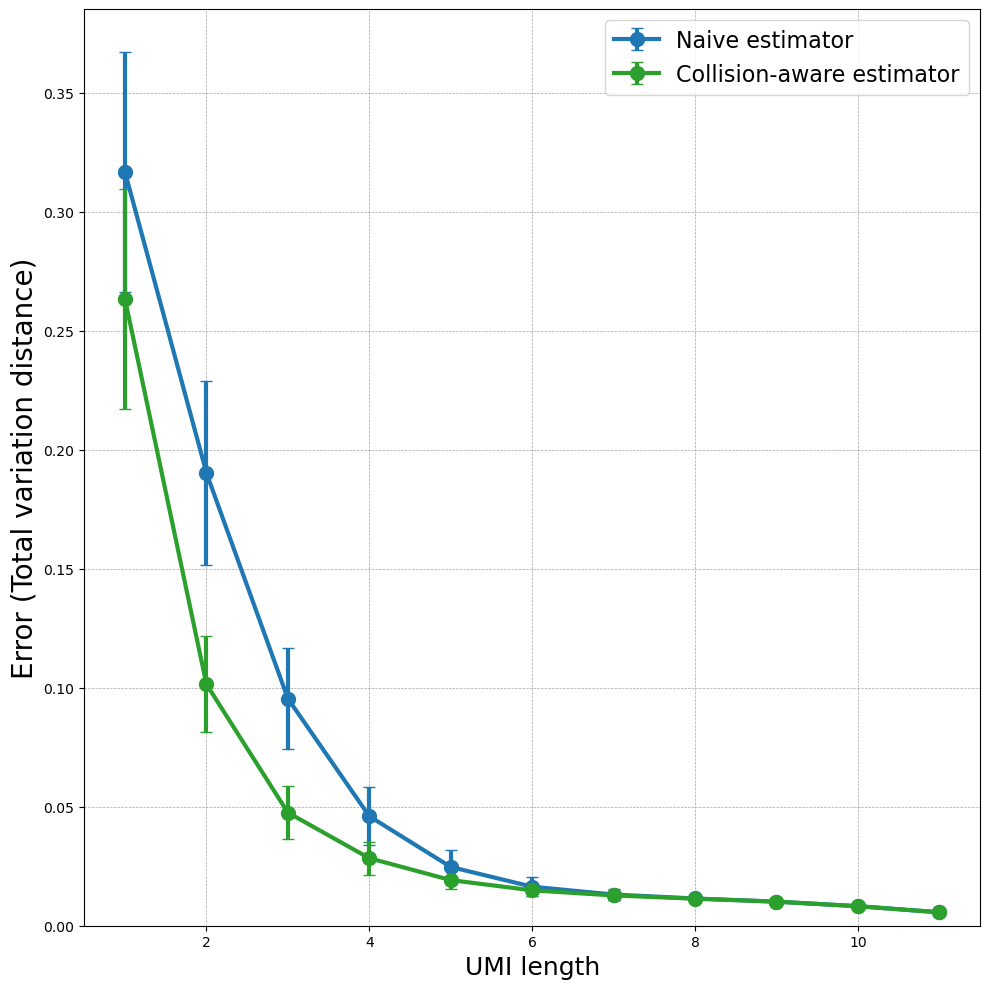

In [3]:
import numpy as np
import scanpy as sc

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

# Loading the regular adata matrices
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices"
common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted adata matrices
# common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices" # rounded 1k
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" # rounded 1k
inverted_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_inverted_{i}.h5ad"
    inverted_adata_dict[i] = sc.read_h5ad(path)

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts1 >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for inverted matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(inverted_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = inverted_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts2 >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))

print(mean_errors)
print(mean_errors2)
import matplotlib.pyplot as plt

# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware estimator'
)

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs
plt.show()


In [15]:
unrounded_means_naive = mean_errors
unrounded_means_model = mean_errors2

In [17]:
rounded_means_naive = mean_errors
rounded_means_model = mean_errors2

In [20]:
# Perform the subtraction with direct NumPy conversion
difference = np.asarray(unrounded_means_model) - np.asarray(rounded_means_model)
difference

array([ 2.28502466e-03, -2.49208469e-04, -2.43993755e-04, -1.82871991e-04,
       -1.93411952e-04, -1.58956294e-04, -9.11858548e-05, -3.54227589e-05,
       -1.49634646e-05, -4.41626997e-06, -1.13739865e-06,  6.33443043e-07])

In [21]:
difference = np.asarray(unrounded_means_model) - np.asarray(rounded_means_model)

# Calculate the percent change
percent_change = (difference / unrounded_means_model) * 100

# Display the result
print("Percent Change:", percent_change)

Percent Change: [ 7.77440563e-01 -1.98573540e-01 -4.03264556e-01 -4.35518268e-01
 -5.90329803e-01 -5.67414322e-01 -3.66579427e-01 -1.59337680e-01
 -7.58150578e-02 -2.75909322e-02 -1.13025321e-02  6.31481910e+01]


In [22]:
# Displaying percent changes in a clean format
for i, change in enumerate(percent_change):
    print(f"Value {i + 1}: {change:.4f}%")

Value 1: 0.7774%
Value 2: -0.1986%
Value 3: -0.4033%
Value 4: -0.4355%
Value 5: -0.5903%
Value 6: -0.5674%
Value 7: -0.3666%
Value 8: -0.1593%
Value 9: -0.0758%
Value 10: -0.0276%
Value 11: -0.0113%
Value 12: 63.1482%


In [27]:
print("Unrounded means")
for i, number in enumerate(unrounded_means_model):
    print(f"Value {i + 1}: {number:.8f}")

Unrounded means
Value 1: 0.29391632
Value 2: 0.12549933
Value 3: 0.06050464
Value 4: 0.04198951
Value 5: 0.03276337
Value 6: 0.02801415
Value 7: 0.02487479
Value 8: 0.02223125
Value 9: 0.01973680
Value 10: 0.01600624
Value 11: 0.01006322
Value 12: 0.00000100


In [26]:
print("Rounded means")
for i, number in enumerate(rounded_means_model):
    print(f"Value {i + 1}: {number:.8f}")

Rounded means
Value 1: 0.29163129
Value 2: 0.12574854
Value 3: 0.06074863
Value 4: 0.04217238
Value 5: 0.03295678
Value 6: 0.02817311
Value 7: 0.02496597
Value 8: 0.02226667
Value 9: 0.01975176
Value 10: 0.01601065
Value 11: 0.01006436
Value 12: 0.00000037


## TVD Plot - MSE

Mean Errors (Regular): [0.00495171839344285, 0.0032926434585900267, 0.0017418200601021108, 0.0007792338051445158, 0.00037980792635171405, 0.00014388216877972142, 2.991596326478139e-05, 7.6082812296424474e-06, 4.656048999815703e-06, 3.4435239450307554e-06, 1.895576252393563e-06, 0.0]
Standard Errors (Regular): [0.012647214513911605, 0.008518800830374795, 0.0067262198729534746, 0.0057518101730259785, 0.004272848046012043, 0.0017711609719053528, 0.00031997380392724355, 3.2694631079420874e-05, 8.148843224357315e-06, 6.32557869461762e-06, 3.4500553949242535e-06, 0.0]
Mean Errors (Inverted): [0.004210506907315651, 0.001947362686851242, 0.0006453795271081775, 0.0003100987705478109, 6.168647396301031e-05, 1.9546046851832624e-05, 8.177510272293176e-06, 5.474923232413428e-06, 4.4699095722327695e-06, 3.426090376658316e-06, 1.8940639983028887e-06, 2.1442480588558292e-11]
Standard Errors (Inverted): [0.010296930852895929, 0.007126649416027496, 0.005616403738011266, 0.003375242682340865, 0.000632315

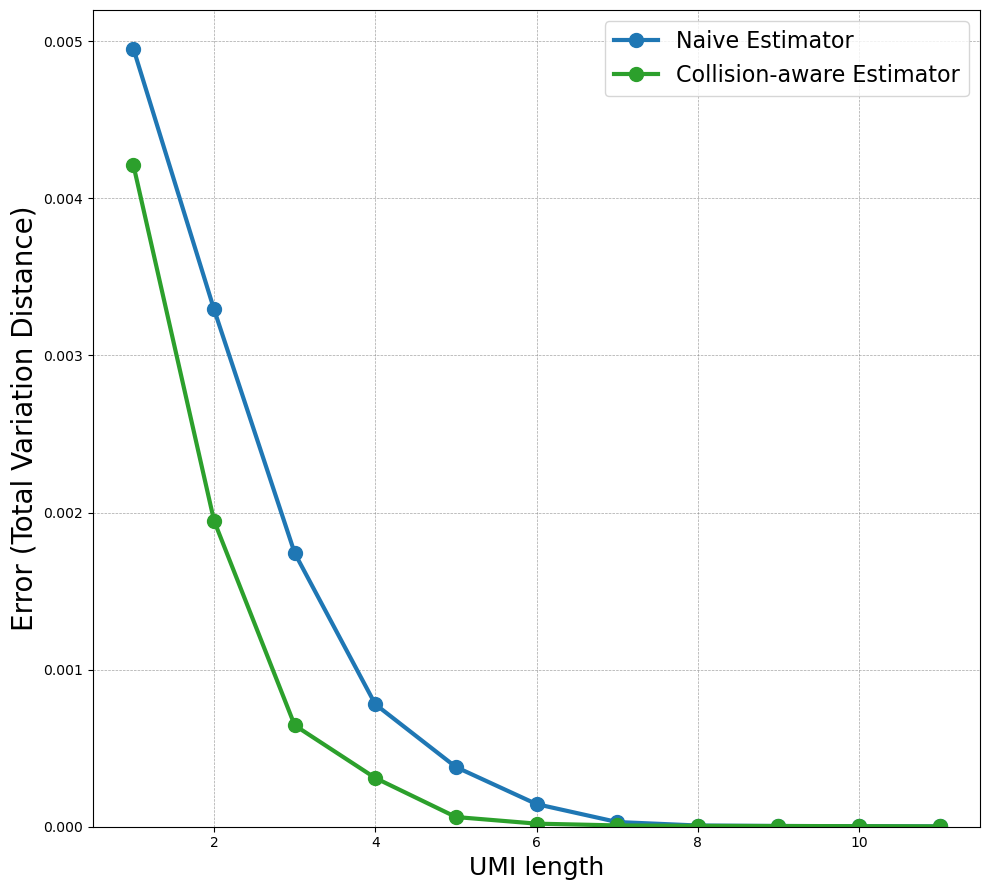

In [5]:
import numpy as np
import scanpy as sc

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return np.sum((p - q)**2)

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted adata matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices"
inverted_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_inverted_{i}.h5ad"
    inverted_adata_dict[i] = sc.read_h5ad(path)

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts1 >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for inverted matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(inverted_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = inverted_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts2 >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))

print("Mean Errors (Regular):", mean_errors)
print("Mean Errors (Inverted):", mean_errors2)

import matplotlib.pyplot as plt

# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 9))


# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total Variation Distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_mse_plot.pdf")
plt.show()




Mean Errors (Naïve):       [0.00495171839344285, 0.0032926434585900267, 0.0017418200601021113, 0.0007792338051445158, 0.00037980792635171405, 0.0001438821687797214, 2.9915963264781396e-05, 7.6082812296424474e-06, 4.656048999815703e-06, 3.4435239450307554e-06, 1.895576252393563e-06, 0.0]
Mean Errors (Collision‑aware): [0.004210506907315651, 0.001947362686851242, 0.0006453795271081775, 0.0003100987705478109, 6.168647396301031e-05, 1.9546046851832627e-05, 8.177510272293174e-06, 5.474923232413427e-06, 4.4699095722327695e-06, 3.426090376658315e-06, 1.8940639983028878e-06, 2.1442480588564922e-11]


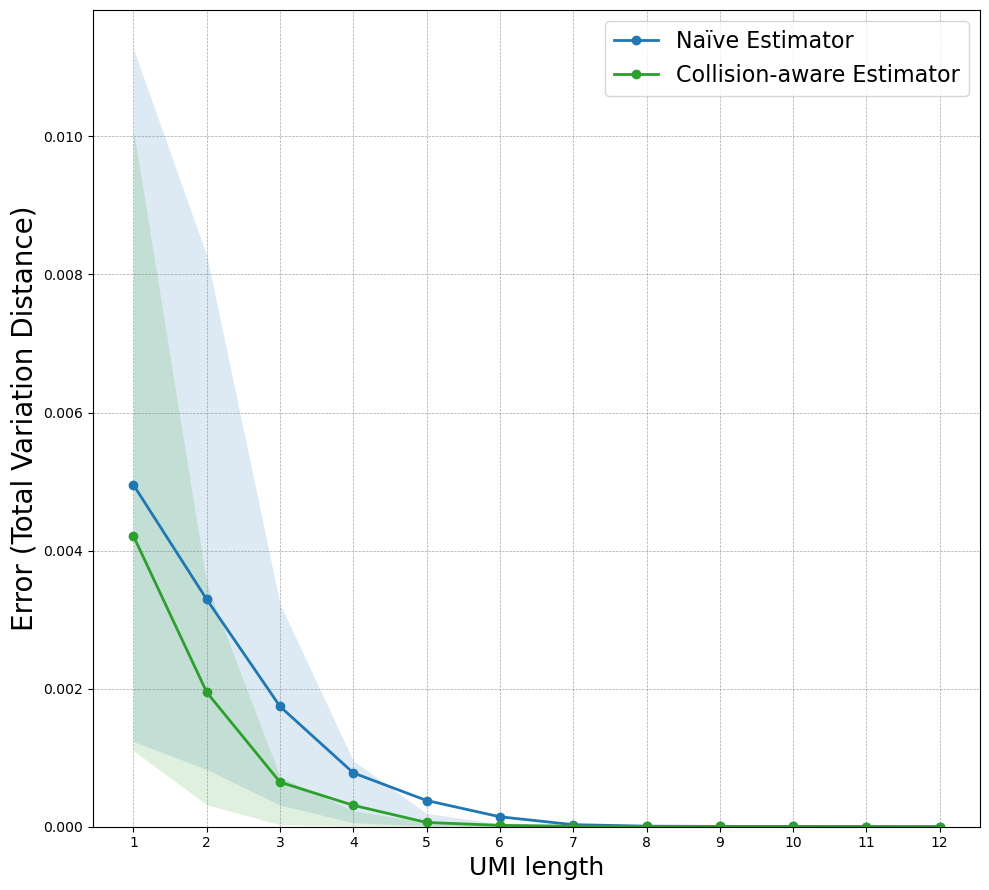

In [4]:
# ──────────────────────────────────────────────────────────────────────────────
# 2) Helper: correct Total‑Variation Distance
def tvd(p, q):
    """
    Total‑Variation Distance ‖p−q‖₁ / 2.
    Both inputs are assumed non‑negative and already on the same support.
    """
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    if p.sum() == 0 or q.sum() == 0:
        raise ValueError("Zero‑mass vector encountered.")
    p /= p.sum()
    q /= q.sum()
    return np.sum((p - q)**2)

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted adata matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices"
inverted_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_inverted_{i}.h5ad"
    inverted_adata_dict[i] = sc.read_h5ad(path)
    

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# ──────────────────────────────────────────────────────────────────────────────
# 3) Gather barcode indices shared by *all* adatas once, so we don’t keep
#    hitting .obs_names inside the inner loop
common_barcodes = set(gt_adata12.obs_names)
for ad in regular_adata_dict.values():
    common_barcodes &= set(ad.obs_names)
for ad in inverted_adata_dict.values():
    common_barcodes &= set(ad.obs_names)
common_barcodes = sorted(common_barcodes)          # deterministic order

# Quick lookup tables: barcode → row index
gt_lookup       = {bc: i for i, bc in enumerate(gt_adata12.obs_names)}
reg_lookup      = {k: {bc: i for i, bc in enumerate(ad.obs_names)}
                   for k, ad in regular_adata_dict.items()}
inv_lookup      = {k: {bc: i for i, bc in enumerate(ad.obs_names)}
                   for k, ad in inverted_adata_dict.items()}

mean_errors, p5_errors, p95_errors   = [], [], []
mean_errors2, p5_errors2, p95_errors2 = [], [], []

# ──────────────────────────────────────────────────────────────────────────────
# 4) Iterate over UMI lengths
for k in range(1, 13):
    e_reg, e_inv = [], []

    for bc in common_barcodes:
        # ---------- regular ----------
        r_idx   = reg_lookup[k][bc]
        gt_idx  = gt_lookup[bc]

        r_vec   = regular_adata_dict[k].X[r_idx]
        gt_vec  = gt_adata12.X[gt_idx]

        if not isinstance(r_vec, np.ndarray):
            r_vec = r_vec.toarray().ravel()
        else:
            r_vec = r_vec.ravel()

        if not isinstance(gt_vec, np.ndarray):
            gt_vec = gt_vec.toarray().ravel()
        else:
            gt_vec = gt_vec.ravel()

        mask    = r_vec >= 1
        if mask.any():                                  # skip empty intersection
            e_reg.append(tvd(r_vec[mask], gt_vec[mask]))

        # ---------- inverted ----------
        inv_idx = inv_lookup[k][bc]
        inv_vec = inverted_adata_dict[k].X[inv_idx]

        if not isinstance(inv_vec, np.ndarray):
            inv_vec = inv_vec.toarray().ravel()
        else:
            inv_vec = inv_vec.ravel()

        mask    = inv_vec >= 1
        if mask.any():
            e_inv.append(tvd(inv_vec[mask], gt_vec[mask]))

    # collect summary stats
    mean_errors.append(np.mean(e_reg))
    p5_errors.append(np.percentile(e_reg, 5))
    p95_errors.append(np.percentile(e_reg, 95))

    mean_errors2.append(np.mean(e_inv))
    p5_errors2.append(np.percentile(e_inv, 5))
    p95_errors2.append(np.percentile(e_inv, 95))

print("Mean Errors (Naïve):      ", mean_errors)
print("Mean Errors (Collision‑aware):", mean_errors2)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Plot with 5th/95th ribbons
import matplotlib.pyplot as plt

umi_lengths = np.arange(1, 13)

plt.figure(figsize=(10, 9))
# --- naïve line + ribbon ---
plt.fill_between(
    umi_lengths, p5_errors,  p95_errors,
    alpha=0.15, color='tab:blue', linewidth=0
)
plt.plot(
    umi_lengths, mean_errors, '-o', label='Naïve Estimator',
    markersize=6, linewidth=2, color='tab:blue'
)
# --- collision‑aware line + ribbon ---
plt.fill_between(
    umi_lengths, p5_errors2, p95_errors2,
    alpha=0.15, color='tab:green', linewidth=0
)
plt.plot(
    umi_lengths, mean_errors2, '-o', label='Collision‑aware Estimator',
    markersize=6, linewidth=2, color='tab:green'
)

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total Variation Distance)', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(umi_lengths)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.savefig(
    "/data/dagyeman/cellranger/bam_file_analysis/"
    "figures_ur/manuscript_figures/1k_tvd_percentile_plot.pdf"
)
plt.show()


Mean Errors (Naïve):            [0.00495171839344285, 0.0032926434585900267, 0.0017418200601021113, 0.0007792338051445158, 0.00037980792635171405, 0.0001438821687797214, 2.9915963264781396e-05, 7.6082812296424474e-06, 4.656048999815703e-06, 3.4435239450307554e-06, 1.895576252393563e-06, 0.0]
Mean Errors (Collision‑aware): [0.004210506907315651, 0.001947362686851242, 0.0006453795271081775, 0.0003100987705478109, 6.168647396301031e-05, 1.9546046851832627e-05, 8.177510272293174e-06, 5.474923232413427e-06, 4.4699095722327695e-06, 3.426090376658315e-06, 1.8940639983028878e-06, 2.1442480588564922e-11]


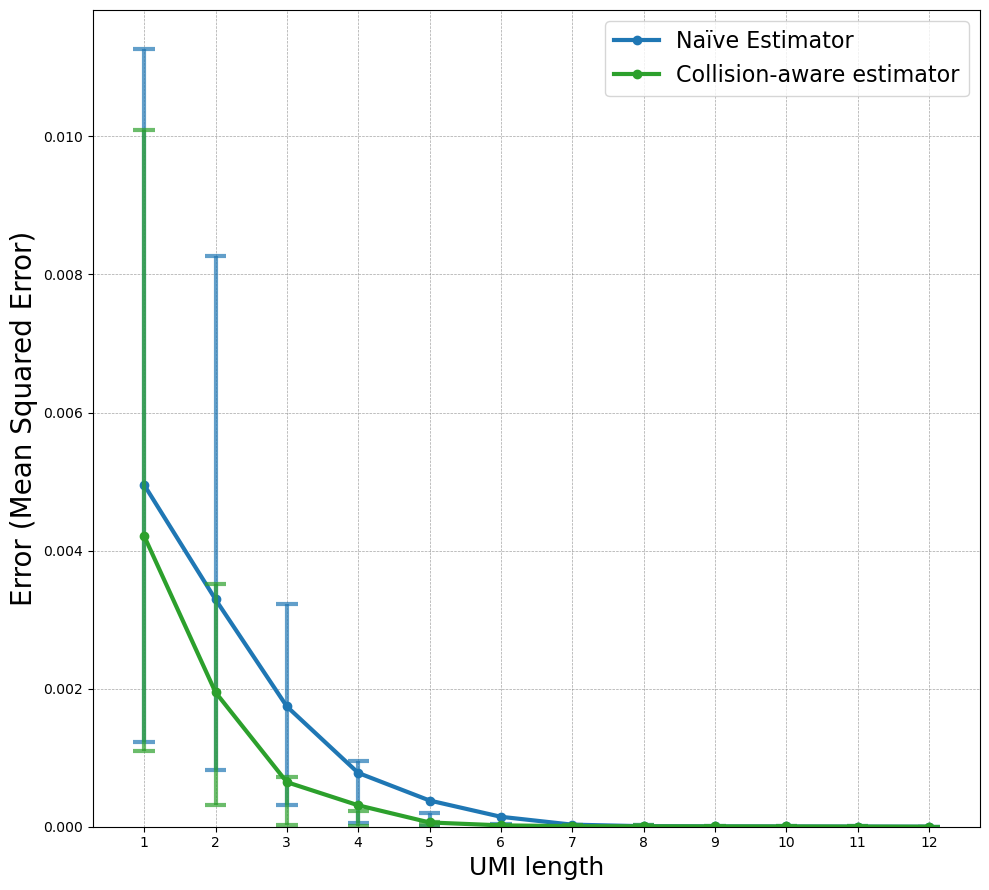

In [12]:
# ──────────────────────────────────────────────────────────────────────────────
# 2) Helper: correct Total‑Variation Distance
def tvd(p, q):
    """
    Total‑Variation Distance ‖p−q‖₁ / 2.
    Both inputs are assumed non‑negative and already on the same support.
    """
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    if p.sum() == 0 or q.sum() == 0:
        raise ValueError("Zero‑mass vector encountered.")
    p /= p.sum()
    q /= q.sum()
    return np.sum((p - q)**2)

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted adata matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices"
inverted_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_inverted_{i}.h5ad"
    inverted_adata_dict[i] = sc.read_h5ad(path)
    
# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# ──────────────────────────────────────────────────────────────────────────────
# 3) Gather barcode indices shared by *all* adatas once, so we don’t keep
#    hitting .obs_names inside the inner loop
common_barcodes = set(gt_adata12.obs_names)
for ad in regular_adata_dict.values():
    common_barcodes &= set(ad.obs_names)
for ad in inverted_adata_dict.values():
    common_barcodes &= set(ad.obs_names)
common_barcodes = sorted(common_barcodes)          # deterministic order

# Quick lookup tables: barcode → row index
gt_lookup       = {bc: i for i, bc in enumerate(gt_adata12.obs_names)}
reg_lookup      = {k: {bc: i for i, bc in enumerate(ad.obs_names)}
                   for k, ad in regular_adata_dict.items()}
inv_lookup      = {k: {bc: i for i, bc in enumerate(ad.obs_names)}
                   for k, ad in inverted_adata_dict.items()}

mean_errors, p5_errors, p95_errors     = [], [], []
mean_errors2, p5_errors2, p95_errors2  = [], [], []

# ──────────────────────────────────────────────────────────────────────────────
# 4) Iterate over UMI lengths
for k in range(1, 13):
    e_reg, e_inv = [], []

    for bc in common_barcodes:
        # ---------- regular ----------
        r_idx   = reg_lookup[k][bc]
        gt_idx  = gt_lookup[bc]

        r_vec   = regular_adata_dict[k].X[r_idx]
        gt_vec  = gt_adata12.X[gt_idx]

        if not isinstance(r_vec, np.ndarray):
            r_vec = r_vec.toarray().ravel()
        else:
            r_vec = r_vec.ravel()

        if not isinstance(gt_vec, np.ndarray):
            gt_vec = gt_vec.toarray().ravel()
        else:
            gt_vec = gt_vec.ravel()

        mask    = r_vec >= 1
        if mask.any():                                  # skip empty intersection
            e_reg.append(tvd(r_vec[mask], gt_vec[mask]))

        # ---------- inverted ----------
        inv_idx = inv_lookup[k][bc]
        inv_vec = inverted_adata_dict[k].X[inv_idx]

        if not isinstance(inv_vec, np.ndarray):
            inv_vec = inv_vec.toarray().ravel()
        else:
            inv_vec = inv_vec.ravel()

        mask    = inv_vec >= 1
        if mask.any():
            e_inv.append(tvd(inv_vec[mask], gt_vec[mask]))

    # collect summary stats
    mean_errors.append(np.mean(e_reg))
    p5_errors.append(np.percentile(e_reg, 5))
    p95_errors.append(np.percentile(e_reg, 95))

    mean_errors2.append(np.mean(e_inv))
    p5_errors2.append(np.percentile(e_inv, 5))
    p95_errors2.append(np.percentile(e_inv, 95))

print("Mean Errors (Naïve):           ", mean_errors)
print("Mean Errors (Collision‑aware):", mean_errors2)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Plot: mean line plus vertical 5th/95th bars drawn manually (no yerr)
import matplotlib.pyplot as plt

umi_lengths = np.arange(1, 13)
cap_width   = 0.15                    # half‑width of the little caps

plt.figure(figsize=(10, 9))

# helper to draw vertical bar + caps
def draw_bar(x, y_low, y_high, color):
    plt.vlines(x, y_low, y_high, color=color, linewidth=3, alpha=0.7)
    plt.hlines(y_low, x - cap_width, x + cap_width, color=color, linewidth=3, alpha=0.7)
    plt.hlines(y_high, x - cap_width, x + cap_width, color=color, linewidth=3, alpha=0.7)

# --- naïve estimator ---
plt.plot(
    umi_lengths, mean_errors, '-o', color='tab:blue',
    markersize=6, linewidth=3, label='Naïve estimator'
)
for x, l, h in zip(umi_lengths, p5_errors, p95_errors):
    draw_bar(x, l, h, 'tab:blue')

# --- collision‑aware estimator ---
plt.plot(
    umi_lengths, mean_errors2, '-o', color='tab:green',
    markersize=6, linewidth=3, label='Collision‑aware estimator'
)
for x, l, h in zip(umi_lengths, p5_errors2, p95_errors2):
    draw_bar(x, l, h, 'tab:green')

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Mean Squared Error)', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(umi_lengths)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.savefig(
    "/data/dagyeman/cellranger/bam_file_analysis/"
    "figures_ur/manuscript_figures/1k_tvd_percentile_plot.pdf"
)
plt.show()




## Celltypist Accuracy Plot

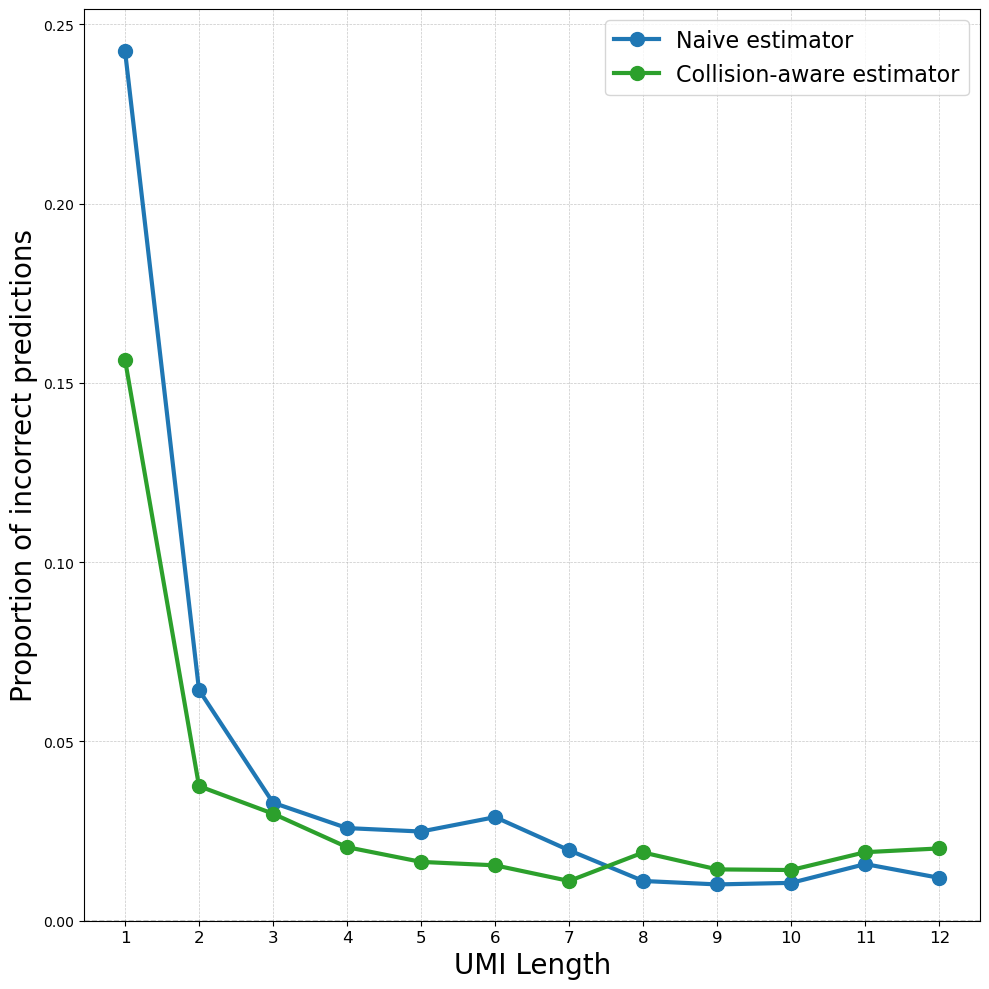

In [14]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Paths
# regular_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
# inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

regular_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Build consensus ground truth from UMI 8–12
#    a) find common cells across UMI 8–12
cells_8_12 = set(annotated_ads_reg[8].obs_names) 
for i in range(9, 13):
    cells_8_12 &= set(annotated_ads_reg[i].obs_names)
common_cells = sorted(cells_8_12)

#    b) majority‐vote per cell
consensus_labels = {}
for cell in common_cells:
    votes = [annotated_ads_reg[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# 3) Prepare ground truth array aligned to common_cells
ground_truth = np.array([consensus_labels[cell] for cell in common_cells], dtype=str)

# 4) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)

for i in range(1, 13):
    # Regular predictions aligned to consensus cells
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = np.array([consensus_labels[c] for c in present], dtype=str)
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to consensus cells
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = np.array([consensus_labels[c] for c in present_inv], dtype=str)
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

# 5) Plot both error curves
plt.figure(figsize=(10, 10))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='o', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Collision-aware estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of incorrect predictions', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(range(1, 13), fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=16)
plt.tight_layout()
out_file = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_error_plot_consensus.pdf"
os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file)
plt.show()
